## Question

Can we use first moment for anchor-word based topic model (instead of forming word-word co-occurence matrix)? Suppose we already know the right anchor words. Now can we represent $L$ (loading) by anchor rows of data?

## Setup
 
 I fit the  [sla dataset](https://zihao12.github.io/ebpmf_data_analysis/data_preprocessing_sla) with `fastTopics`. Then I use the fitted multinomial model to generate simulated count data. I can change the document length to make the estimation problem easier or harder. 
 
 ## What I found
 
 * Directly using counts of anchor words to represent $L$ is a terrible idea.
 * Get much better estimate of $L$ from anchor words by doing sinkhorn + truncated SVD denoising. But it's still very far from MLE... Also estimate of $A$ seems much better. Maybe it's still preferable to use the second moment. 

In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD


from scipy.io import mmread
script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions_anchor import *
from misc import *
from sinkhorn import * 

datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"

np.random.seed(123)

## load true model and simulated data

In [2]:
## load data
dataname = "sla"
k = 6
rate=3

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
Xt = fitted['X'].T.toarray() ## p by n
Lt = fitted['Ltrue'].T ## k by n
F = fitted['Ftrue']
B0 = fitted['B0']
A0 = fitted['A0']
B2 = fitted['B2']
A2 = fitted['A2']
S = fitted['S0']

## Anchor words exist, and $A$ can be estimated well (2nd moment method)

In [3]:
idx = match_topics(F, B0).astype(int)
F[S[idx],:].round(3)

array([[0.004, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.024, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.001, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.003, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.008, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.004]])

In [4]:
print("A0.round(3)")
print(A0.round(3))
print("A2.round(3)")
print(A2.round(3)) ## estimated using true anchor words

A0.round(3)
[[0.136 0.018 0.024 0.017 0.022 0.016]
 [0.018 0.084 0.014 0.008 0.011 0.01 ]
 [0.024 0.014 0.109 0.006 0.018 0.016]
 [0.017 0.008 0.006 0.065 0.005 0.008]
 [0.022 0.011 0.018 0.005 0.115 0.013]
 [0.016 0.01  0.016 0.008 0.013 0.08 ]]
A2.round(3)
[[0.146 0.023 0.032 0.02  0.024 0.018]
 [0.023 0.084 0.011 0.008 0.01  0.008]
 [0.032 0.011 0.097 0.007 0.018 0.014]
 [0.02  0.008 0.007 0.062 0.004 0.007]
 [0.024 0.01  0.018 0.004 0.107 0.01 ]
 [0.018 0.008 0.014 0.007 0.01  0.077]]


## Can we use anchor words in original count data to find $L$?

Seems not as seen below. Observations are just $0,1,2,3$ in most documents; too noisy

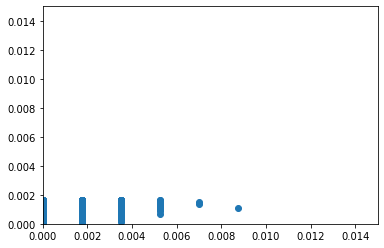

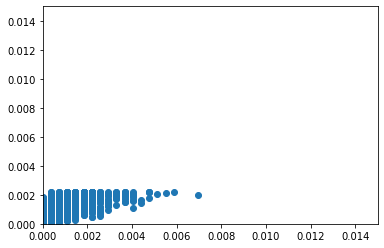

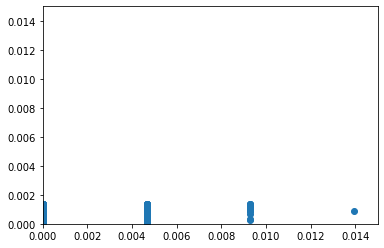

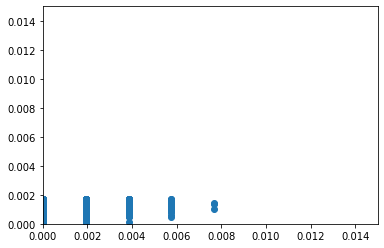

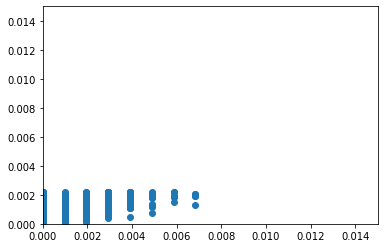

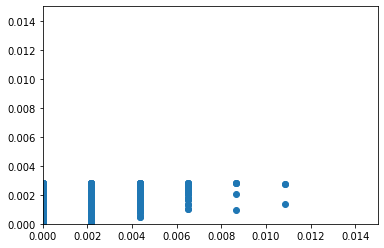

In [5]:
for i in range(k):
    anchor_row = Xt[S[idx[i]],:]
    anchor_row /= anchor_row.sum()
    l = Lt[i,:] / Lt[i,:].sum()
    plt.scatter(anchor_row, l)
    plt.xlim([0, 0.015])
    plt.ylim([0, 0.015])
    plt.show()

After we do the sinkhorn?

 Still very bad

In [6]:
Xtn,r, c = sinkhorn(X = Xt)

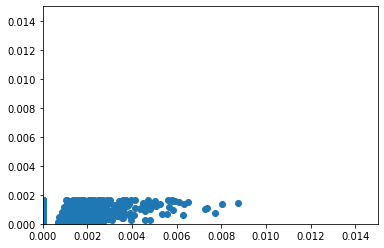

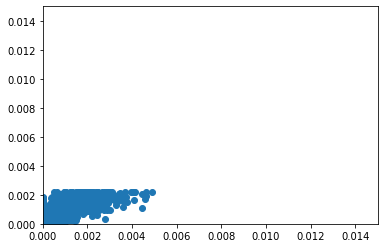

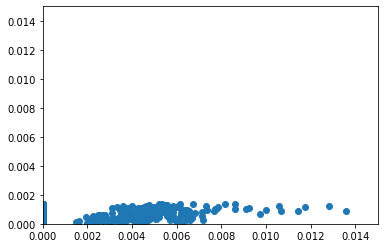

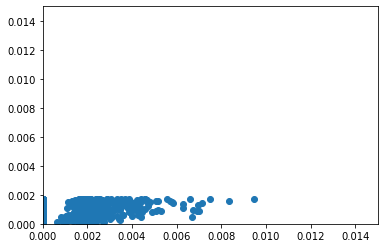

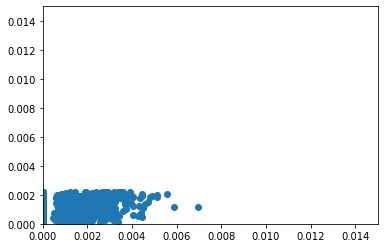

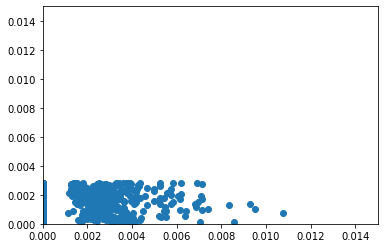

In [7]:
for i in range(k):
    anchor_row = Xtn[S[idx[i]],:]
    anchor_row /= anchor_row.sum()
    l = Lt[i,:] / Lt[i,:].sum()
    plt.scatter(anchor_row, l)
    plt.xlim([0, 0.015])
    plt.ylim([0, 0.015])
    plt.show()

### Sinkhorn + truncated SVD 

In [8]:
r = 200
svd = TruncatedSVD(n_components=r, random_state=42)
US = svd.fit_transform(Xtn)
Xtn_tsvd2 = US @ svd.components_

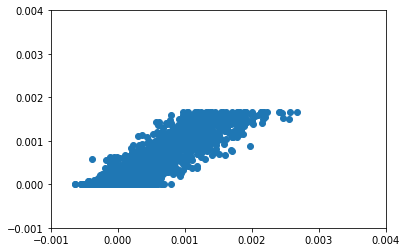

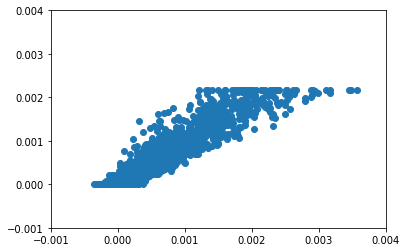

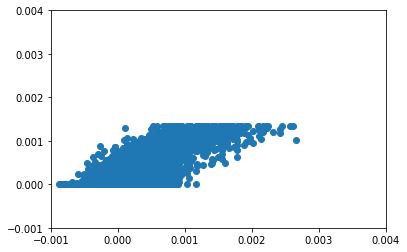

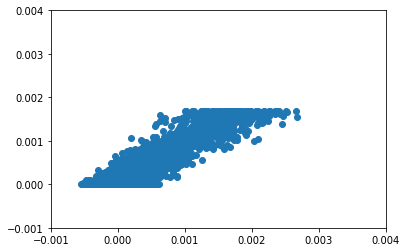

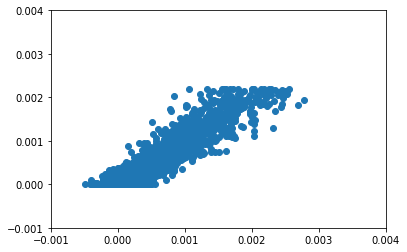

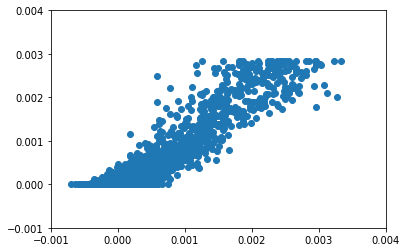

In [9]:
for i in range(k):
    anchor_row = Xtn_tsvd2[S[idx[i]],:]
    anchor_row /= anchor_row.sum()
    l = Lt[i,:] / Lt[i,:].sum()
    plt.scatter(anchor_row, l)
    plt.xlim([-0.001, 0.004])
    plt.ylim([-0.001, 0.004])
    plt.show()

### Comment:

* Sinkhorn + SVD helps get better estimate of $L$ from anchor rows / words of count matrix
* However, estimate error is still pretty large for $L$, especially when data is sparser (use `rate = 1`, not shown here; much worse) (TODO: need to compare with MLE)
* The idea of estimating $L$ from anchor rows/words of $X^T$ seems problematic: not only is $\hat{L}$ bad, it can also affect estimate of $F$. 

## Issue with SVD

Below I show the issue of truncated SVD for something non-negative, through forming $\frac{1}{n} L^T L$ where $L$ is estimated from previous method

Setting negative entries in $L$ to 0

In [10]:
Anchor_rows = Xtn_tsvd2[S[idx],:]
Anchor_rows[Anchor_rows < 0 ] = 0
# Anchor_rows /= Anchor_rows.sum(axis=1)[:,None]
Anchor_rows /= Anchor_rows.sum(axis=0)[None,:]
Ahat = (Anchor_rows @ Anchor_rows.T) / Anchor_rows.shape[1] 
Ahat.round(3)

array([[0.085, 0.016, 0.024, 0.02 , 0.019, 0.013],
       [0.016, 0.076, 0.018, 0.014, 0.013, 0.014],
       [0.024, 0.018, 0.077, 0.022, 0.017, 0.019],
       [0.02 , 0.014, 0.022, 0.086, 0.016, 0.013],
       [0.019, 0.013, 0.017, 0.016, 0.083, 0.016],
       [0.013, 0.014, 0.019, 0.013, 0.016, 0.084]])

What if I don't set negative parts of $\hat{L}$ to 0? Turns out very different

In [11]:
Anchor_rows = Xtn_tsvd2[S[idx],:]
# Anchor_rows /= Anchor_rows.sum(axis=1)[:,None]
Anchor_rows /= Anchor_rows.sum(axis=0)[None,:]
Ahat = (Anchor_rows @ Anchor_rows.T) / Anchor_rows.shape[1] 
Ahat.round(3)

array([[ 2.138, -0.204, -0.813, -0.515, -0.39 , -0.066],
       [-0.204,  1.836, -1.349, -0.567,  0.165,  0.258],
       [-0.813, -1.349,  1.991,  0.811, -0.341, -0.102],
       [-0.515, -0.567,  0.811,  0.624, -0.156, -0.011],
       [-0.39 ,  0.165, -0.341, -0.156,  1.175, -0.262],
       [-0.066,  0.258, -0.102, -0.011, -0.262,  0.319]])